In [1]:
# Python imports
import sys, numpy as np
# Torch
import torch, torchvision, torch.nn as nn, torch.optim as optim
# Navigation MDP
import navigation_mdp as NvMDP
# RL utils
import rl.planning as Plan
import rl.policy as Policy
from rl.model import RewardLinear, RewardConvAE
# Utils
from utils.utils import *
from utils.plotting import NavGridViewPlotter as NvPlotter, plot_grid_data_helper
# Matplotlib
from matplotlib import cm as cm, pyplot as plt, colors as mplotcolors
%load_ext autoreload
%autoreload 2

## Gridworld 5x7

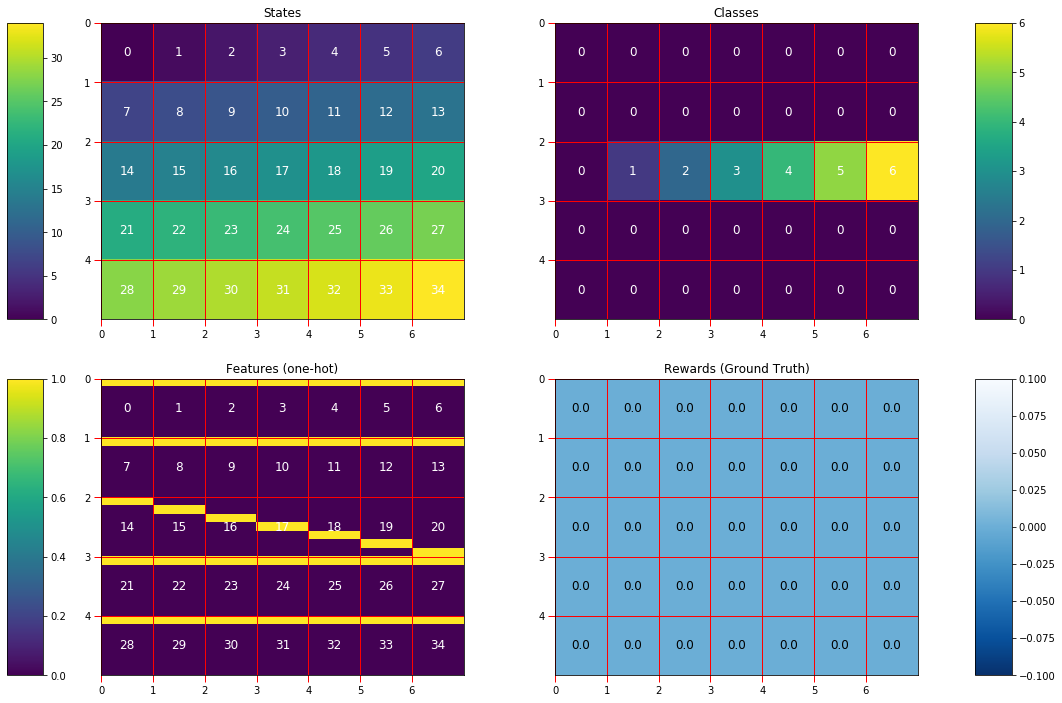

In [2]:
np.random.seed(5)
# Specify state space
S = NvMDP.state.DiscreteStateSpace(5,7)
goal = (2,6)
# Attach classes
class_ids = NvMDP.class_.XYClassDistribution([
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]])().flatten()
S.attach_classes(class_ids)
# Attach features
S.attach_features(NvMDP.features.FeatureClassIndicatorOneHot(S))
# Attach rewards
S.attach_rewards(NvMDP.reward.RewardStateScalar(S, 
                    loc_to_reward_dict={goal: 0.}, class_id_to_reward_dict={}, default=0))
R = S.rewards()
# Specify dynamics
T = NvMDP.dynamics.XYDynamics(S, slip_prob=0.)
# Set goal
# S.set_terminal_status_by_loc([goal])


plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
NvPlotter(S).plot_states(
    cmap=cm.viridis, ann_col="white", 
    title="States").colorbar(where="left", pad=0.8, size="10%").grid()
plt.subplot(2,2,2)
NvPlotter(S).plot_classes(
    cmap=cm.viridis, ann_col="white", 
    title="Classes").colorbar(where="right", pad=0.8, size="10%").grid()
plt.subplot(2,2,3)
NvPlotter(S).plot_features(
    ann=S.idxs.flatten(), cmap=cm.viridis, ann_col="white", 
    title="Features (one-hot)").colorbar(where="left", pad=0.8, size="10%").grid()
plt.subplot(2,2,4)
NvPlotter(S).plot_rewards(
    cmap=cm.Blues_r, title="Rewards (Ground Truth)").colorbar(where="right", pad=0.8, size="10%").grid()

RewardLinear(
  (w): Linear(in_features=7, out_features=1, bias=False)
  (sigmoid): Sigmoid()
)


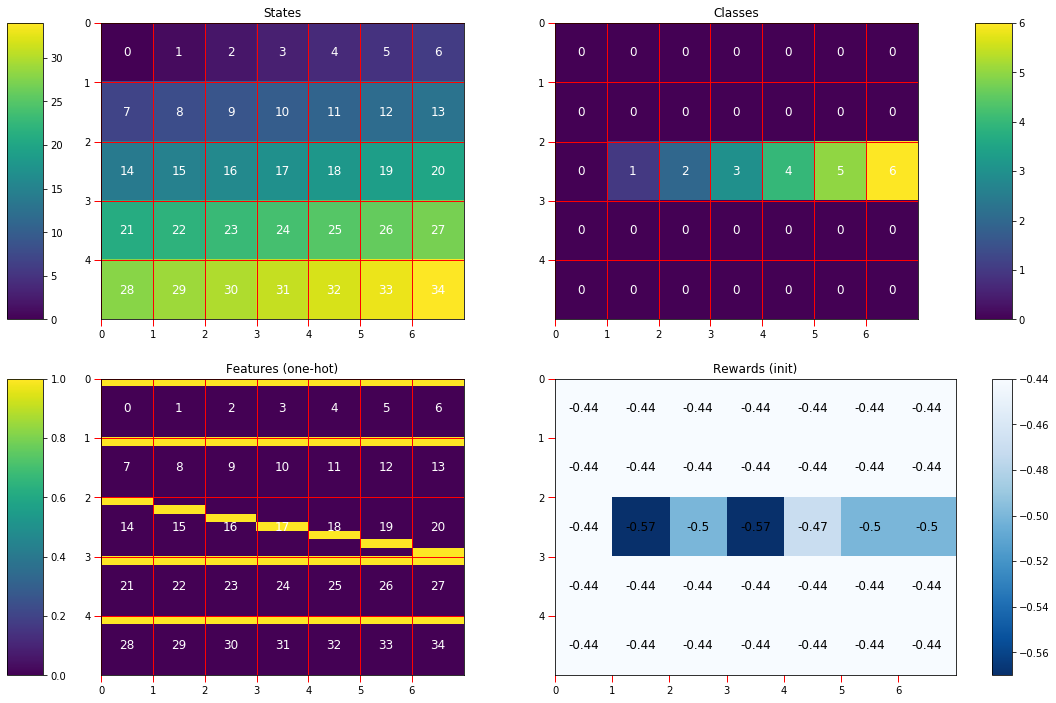

In [3]:
PHI = torch.FloatTensor(S.features())
R_model = RewardLinear(PHI[0].numpy().shape[0], lr=0.1, weight_decay=0.)
print(R_model)

plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
NvPlotter(S).plot_states(
    cmap=cm.viridis, ann_col="white", 
    title="States").colorbar(where="left", pad=0.8, size="10%").grid()
plt.subplot(2,2,2)
NvPlotter(S).plot_classes(
    cmap=cm.viridis, ann_col="white", 
    title="Classes").colorbar(where="right", pad=0.8, size="10%").grid()
plt.subplot(2,2,3)
NvPlotter(S).plot_features(
    ann=S.idxs.flatten(), cmap=cm.viridis, ann_col="white", 
    title="Features (one-hot)").colorbar(where="left", pad=0.8, size="10%").grid()
plt.subplot(2,2,4)
NvPlotter(S).plot_array(R_model(PHI).detach().numpy().round(2), 
                           cmap=cm.Blues_r, title="Rewards (init)").colorbar(where="right", pad=0.5)

In [4]:
# # T.ACTIONS: ['U', 'D', 'L', 'R']
# Sk = S.at_loc((2,2))
# Ak = "U"
S.at_loc((2,6)).set_terminal_status(True)
log_likelihoods_history = []

for _iter in range(20):
    _iter_start_time = time.time()
    R_model.zero_grad()
    
    VI = Plan.ValueIteration(S, R_model(PHI), T, verbose=True, log_pi=False, gamma=0.99)
#     log_Pi, V, Q, iterno = VI.run(100, lambda q: Policy.Greedy(q), 
#                                   verbose=True, debug=False, eps=1e-6)
    Pi, V, Q, iterno = VI.run(100, lambda q: Policy.Boltzmann(q, boltzmann_temp=.1), 
                                  verbose=True, debug=False, eps=1e-6)
    values = V.detach().numpy().round(2)
    loss = 0
    for i in range(6):
        loss += -torch.log(Pi[VI.get_tbl_idxs(S.at_loc((2,0+i)), "R")])
#         print(Pi[VI.get_tbl_idxs(S.at_loc((2,1+i)), "R")], loss)
        
    ll = np.exp(-loss.detach().item())
    log_likelihoods_history.append(ll)
    
    print("\n>>> Iter: {:04d} ({:03.3f}s): loss = {:09.6f}, likelihood = {:02.4f}\n\n".format(
                    _iter, time.time()-_iter_start_time, loss, ll))
    loss.backward()
    R_model.step()
    # print(torch.sum(R_model.fc1.weight.grad))
#     print(torch.sum(R_model.w.weight.grad))

Running VI [  ] VI converged @ 15.

>>> Iter: 0000 (0.262s): loss = 00.036155, likelihood = 0.9645


Running VI [  ] VI converged @ 14.

>>> Iter: 0001 (0.242s): loss = 00.015785, likelihood = 0.9843


Running VI [  ] VI converged @ 14.

>>> Iter: 0002 (0.227s): loss = 00.012606, likelihood = 0.9875


Running VI [  ] VI converged @ 13.

>>> Iter: 0003 (0.210s): loss = 00.010851, likelihood = 0.9892


Running VI [  ] VI converged @ 13.

>>> Iter: 0004 (0.216s): loss = 00.009629, likelihood = 0.9904


Running VI [  ] VI converged @ 13.

>>> Iter: 0005 (0.213s): loss = 00.008714, likelihood = 0.9913


Running VI [  ] VI converged @ 12.

>>> Iter: 0006 (0.198s): loss = 00.007999, likelihood = 0.9920


Running VI [  ] VI converged @ 12.

>>> Iter: 0007 (0.195s): loss = 00.007426, likelihood = 0.9926


Running VI [  ] VI converged @ 13.

>>> Iter: 0008 (0.212s): loss = 00.006956, likelihood = 0.9931


Running VI [  ] VI converged @ 13.

>>> Iter: 0009 (0.221s): loss = 00.006561, likelihood =

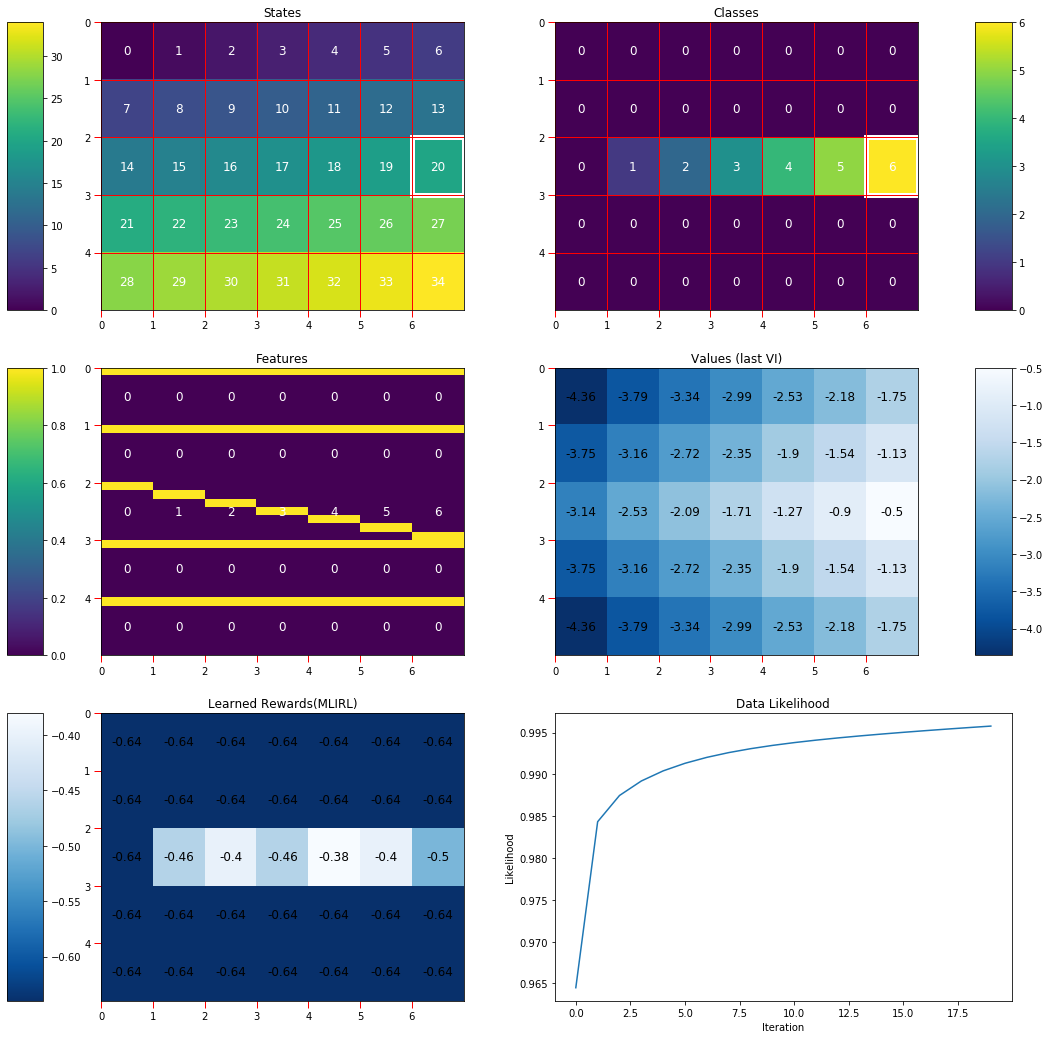

In [5]:
plt.figure(figsize=(18,18))
plt.subplot(3,2,1)
NvPlotter(S).plot_states(
    cmap=cm.viridis, ann_col="white", 
    title="States").colorbar(where="left", pad=0.8, size="10%").grid()
plt.subplot(3,2,2)
NvPlotter(S).plot_classes(
    cmap=cm.viridis, ann_col="white", 
    title="Classes").colorbar(where="right", pad=0.8, size="10%").grid()
plt.subplot(3,2,3)
NvPlotter(S).plot_features(
    ann_col="white", cmap=cm.viridis).colorbar(where="left", pad=.8, size="10%")
plt.subplot(3,2,4)
NvPlotter(S).plot_array(values,
                           cmap=cm.Blues_r, title="Values (last VI)").colorbar(where="right", pad=0.8, size="10%")
plt.subplot(3,2,5)
NvPlotter(S).plot_array(R_model(PHI).detach().numpy().round(2), 
                           cmap=cm.Blues_r, title="Learned Rewards(MLIRL)").colorbar(where="left", pad=0.8, size="10%")
plt.subplot(3,2,6)
plt.plot(range(len(log_likelihoods_history)), log_likelihoods_history)
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.title("Data Likelihood")
plt.savefig("./figures/mlirl_gw_5x7_one_hot__traj_straight")